## Bike Rental Project 

Importing all needed modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import numpy as np

/home/nolan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [ ]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")

Checking the imported data

In [5]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Checking the distribution of the cnt column. 

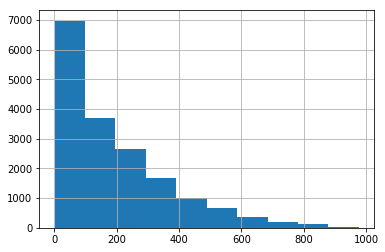

In [6]:
bike_rentals["cnt"].hist()
plt.show()

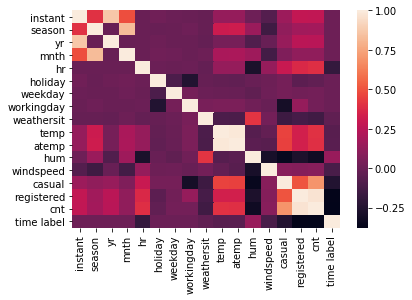

In [14]:
sns.heatmap(bike_rentals.corr())

Creating a function that will group the hour column values into morning, afternoon, evening and night. Bundling similar times together like this allows the algorithm to make better use of this column. 

In [10]:
def assign_label(val):
    if val >= 6 and val < 12:
        return 1
    elif val >=12 and val < 18:
        return 2
    elif val >=18 and val <24:
        return 3
    else:
        return 4



In [8]:
bike_rentals["time label"] = bike_rentals["hr"].apply(assign_label)

In [18]:
samp_size = int(math.floor(bike_rentals.shape[0]*0.8))

train = bike_rentals.sample(samp_size)

In [11]:
bike_rentals.index.isin(train.index)

array([ True,  True,  True, ..., False, False,  True], dtype=bool)

In [19]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [20]:
test.shape[0]

3476

We must remove the cnt, casual and registered columns since they will leak information on the predicted variable to our algorithm. The dteday column is not useful to us and so we remove that too.

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")


In [22]:
dtr = DecisionTreeRegressor(min_samples_leaf=5)

dtr.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Comparing our predictions to the testing target values. We will use the root mean squred to calculate the error, since our target variable has continuous, numeric values. it is not hard to see why the error is large. As we see in the histogram of the cnt column, there are a small number of times where a very large number of bikes are rented. This will cause a large mean squared error which heavily punishes large error values. 

In [25]:
predictions = dtr.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

2907.3353181066964

Let's try to improve our predictions by using a random forest algorithm. Because they average the results of many trees, they are loss prone to overfitting and should provide better predictions. 

In [27]:
rfr = RandomForestRegressor(min_samples_leaf=5)
rfr.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
predictions_rfr = rfr.predict(test[predictors])

We see that the error using the random forest method reduces our error. 

In [41]:
np.mean((predictions_rfr - test["cnt"]) ** 2)

2108.24384233299